# Sudoku
----------
Celem ćwiczenia było napisanie algorytmy wykorzystującego metodę symulowanego wyżarzania w celu rozwiązania sudoku 

In [1]:
import matplotlib.pyplot as plt
import random
import math
from tqdm import tqdm

# Funkcje pomocnicze:

#### Wczytywanie sudoku:

In [15]:
def readFromFile(filename):
    with open(filename) as file:
        sudoku = file.read()
    sudoku = sudoku.splitlines()
    sudoku = list(map(lambda x : list(x), sudoku))
    return sudoku

#### Znajdowanie wszystkich pól w klastrze dla danego punktu:

In [3]:
def cluster(x,y):
    clusterRow = x//3
    clusterCol = y//3
    return [(i + clusterRow*3,j + clusterCol*3) for i in range(3) for j in range(3)]

#### Funkcje kosztu:
-------
##### cost_all:
    Funkcja liczy koszt (powtórzenie elementów) dla każdego pola w sudoku
##### cost_lines_clusters:
    Funkcja liczy ilość powtarzających się elementów dla każdego klastra oraz wiersza (założenie, że przykładowe
    rozwiązanie zostaje wygenerowane poprzez poprawne uzupełnienie sudoku wg kolumn)

In [4]:
def cost(checked_field, sudoku):
    cost = 0
    for field in cluster(*checked_field):
        if (sudoku[checked_field[0]][checked_field[1]] == sudoku[field[0]][field[1]]) and (field != checked_field):
            cost += 1
    for col_num in range(9):
        if (sudoku[checked_field[0]][checked_field[1]] == sudoku[checked_field[0]][col_num]) and (col_num != checked_field[1]):
            cost += 1
    return cost

def cost_all(sudoku):
    final_cost = 0
    for x in range(len(sudoku)):
        for y in range(len(sudoku[0])):
            final_cost += cost((x,y), sudoku)
    return final_cost

def cost_lines_clusters(sudoku):
    final_cost = 0
    for x in range(9):
        final_cost += (9 - len(set(sudoku[x])))
    for x in [0,3,6]:
        for y in [0,3,6]:
            final_cost += 9 - len(set([sudoku[i[0]][i[1]] for i in cluster(x,y)]))
    return final_cost

#### Funkcje prawdopodobieństwa akceptacji oraz przykładowa funkcja zmiany temperatury:

In [5]:
def acceptance_probability(old_cost, new_cost, T):
    if new_cost < old_cost:
        return 1.0
    else:
        return math.exp(-abs(new_cost - old_cost) / T)

def temp(T):
    return T * 0.9995

#### Generowanie przykładowego rozwiązania sudoku, w którym każda kolumna spełnia wymagania poprawnego rozwiązania:

In [6]:
def generate_random_solution(sudoku):
    for col_num in range(9):
        col = [i for i in range(1,10)]
        for row_num in range(9):
            if sudoku[row_num][col_num] != 'x':
                tmp = col[row_num]
                index = col.index(int(sudoku[row_num][col_num]))
                col[row_num] = sudoku[row_num][col_num]
                col[index] = tmp
        for row_num in range(9):
            sudoku[row_num][col_num] = int(col[row_num])

#### Losowa zamiana 2 elementów wewnątrz jednej kolumny:

In [7]:
def random_change(sudoku, base_sudoku):
    possible_choices = []
    while(len(possible_choices) < 2):
        col_num = random.randint(0,8)
        possible_choices = [i for i in range(9) if base_sudoku[i][col_num] == 'x']
    i,j = random.sample(possible_choices, 2)
    sudoku[i][col_num], sudoku[j][col_num] = sudoku[j][col_num], sudoku[i][col_num]
    return (i, col_num), (j, col_num)

#### Prints and Plots:

In [8]:
def sudokuPrint(sudoku):
    for x in range(len(sudoku)):
        if x % 3 == 0 and x !=0:
            print(" ---------------------")
        for y in range(len(sudoku[0])):
            if y % 3 == 0 and y != 0:
                print(" |", end='')
            print(" " + str(sudoku[x][y]), end='')
        print("\n", end='')

In [9]:
def plot_costs(costs):
    plt.plot(costs)
    plt.show()

# Simulated Annealling:

In [10]:
def sim_anneal(base_sudoku, change_fun, cost_fun=cost_all, temp_fun=temp,
               acceptance_probability_fun=acceptance_probability, T=1000, min_temp=1e-4, max_unrelevant_iter=2000):
    points = list([list(row) for row in base_sudoku])
    generate_random_solution(points)
    
    candidate = list([list(row) for row in points])
    best_res = list([list(row) for row in points])
    curr_cost = cost_fun(points)
    best_cost = curr_cost
    costs = [curr_cost]
    
    count = 0
    iteration = 0
    while T > min_temp and count < max_unrelevant_iter:
        point_a, point_b = change_fun(candidate, base_sudoku)
        iteration += 1

        T = temp_fun(T)
        new_cost = cost_fun(candidate)
        if(random.random() < acceptance_probability_fun(curr_cost, new_cost, T)):
            if new_cost != curr_cost:
                count = 0
            points[point_a[0]][point_a[1]], points[point_b[0]][point_b[1]] = points[point_b[0]][point_b[1]], points[point_a[0]][point_a[1]]
            curr_cost = cost_fun(points)
            if(curr_cost < best_cost):
                best_res = list(list(row) for row in points)
                best_cost = curr_cost
        else:
            count += 1
            candidate[point_a[0]][point_a[1]], candidate[point_b[0]][point_b[1]] = candidate[point_b[0]][point_b[1]], candidate[point_a[0]][point_a[1]]
        costs.append(curr_cost)
    return (best_res, costs, iteration)

# Tests:

In [11]:
sudoku = readFromFile("ex/free45/0")
sudokuPrint(sudoku)
%time res, costs, _ = sim_anneal(sudoku, random_change, T=20, cost_fun=cost_lines_clusters, temp_fun=lambda x: x * 0.9998, min_temp=1e-5)

 x x 1 | 7 x x | 5 x 9
 5 7 3 | x 2 4 | 1 x 6
 8 x x | 5 x 1 | x x 2
 ---------------------
 7 x x | 2 9 5 | x 1 8
 x x 9 | 4 x x | 3 x 5
 6 5 2 | 8 x x | x x 7
 ---------------------
 4 6 5 | x 8 x | x 7 1
 x x x | 1 5 9 | x x 4
 9 x 8 | x x 7 | x 5 3
CPU times: user 2.89 s, sys: 49 ms, total: 2.94 s
Wall time: 3.14 s


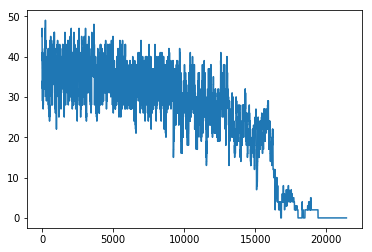

In [12]:
plot_costs(costs)

Wykres wygląda w ten sposób, ponieważ zostało nałożone górne ograniczenie na liczbę nic nie wnoszących iteracji 
(jeżeli przez 2000 (domyślnie) iteracji nie zamieniono żadnego elementu - skończ działanie algorytmu.

In [13]:
sudokuPrint(res)

 2 4 1 | 7 6 8 | 5 3 9
 5 7 3 | 9 2 4 | 1 8 6
 8 9 6 | 5 3 1 | 7 4 2
 ---------------------
 7 3 4 | 2 9 5 | 6 1 8
 1 8 9 | 4 7 6 | 3 2 5
 6 5 2 | 8 1 3 | 4 9 7
 ---------------------
 4 6 5 | 3 8 2 | 9 7 1
 3 2 7 | 1 5 9 | 8 6 4
 9 1 8 | 6 4 7 | 2 5 3


In [14]:
cost_lines_clusters(res)

0

## Test na wielu przykładach:
-----
### Aby sprawdzić efektywność rozwiązań, przetestowałem obydwie funkcje na wielu różnych przykładach sudoku:

In [510]:
iter_num = {45: [], 50: [], 55: [], 60: [], 65: []}
mistakes = {45: [], 50: [], 55: [], 60: [], 65: []}
for free in [45,50,55,60,65]:
    for id in tqdm(range(20)):
        sudoku = readFromFile("ex/free" + str(free) + "/" + str(id))
        res, costs, iterations = sim_anneal(sudoku, random_change, T=300, temp_fun=lambda x: x * 0.9995, min_temp=1e-5)
        iter_num[free].append(iterations)
        mistakes[free].append(cost_lines_clusters(res))

100%|██████████| 20/20 [06:31<00:00, 19.97s/it]


##### Średni błąd rozwiązania względem liczby pustych miejsc:

In [511]:
for x in [45, 50, 55, 60, 65]:
    print(x, sum(mistakes[x])/20.0)

45 0.1
50 1.2
55 2.75
60 4.75
65 5.55


##### Błędy:

In [520]:
mistakes

{45: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
 50: [4, 0, 0, 2, 0, 0, 2, 0, 2, 0, 6, 2, 0, 0, 2, 2, 0, 0, 2, 0],
 55: [4, 2, 5, 0, 0, 2, 6, 2, 4, 0, 0, 7, 2, 4, 6, 2, 2, 5, 2, 0],
 60: [9, 6, 2, 4, 4, 10, 0, 4, 4, 7, 6, 2, 6, 4, 2, 7, 4, 4, 6, 4],
 65: [5, 5, 5, 4, 8, 6, 6, 5, 8, 4, 5, 4, 7, 7, 6, 2, 6, 5, 7, 6]}

Jak można zauważyć, dla mniejszej liczby wolnych miejsc algorytm ma lepsze wyniki, natomiast rozwiązania nie są poprawne, jeżeli liczba wolnych pól wynosi 65

###### Średnia liczba iteracji względem liczby pustych miejsc:

In [512]:
for x in [45, 50, 55, 60, 65]:
    print(x, sum(iter_num[x])/20.0)

45 13970.55
50 14112.6
55 14545.3
60 14945.75
65 15453.45


### Test z wykorzystaniem funkcji zliczającej liczbę powtórzeń w wierszu oraz w klastrze:

In [527]:
iter_num_o = {45: [], 50: [], 55: [], 60: [], 65: []}
mistakes_o = {45: [], 50: [], 55: [], 60: [], 65: []}
for free in [45,50,55,60,65]:
    for id in tqdm(range(20)):
        sudoku = readFromFile("ex/free" + str(free) + "/" + str(id))
        res, costs, iterations = sim_anneal(sudoku, random_change, T=30, cost_fun=cost_lines_clusters, temp_fun=lambda x: x * 0.9995, min_temp=1e-5)
        iter_num_o[free].append(iterations)
        mistakes_o[free].append(cost_lines_clusters(res))

100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


Średni błąd rozwiązania względem liczby pustych miejsc:

In [528]:
for x in [45, 50, 55, 60, 65]:
    print(x, sum(mistakes_o[x])/20.0)

45 0.1
50 0.75
55 3.25
60 4.05
65 5.3


Średnia liczba iteracji względem liczby pustych miejsc:

In [529]:
for x in [45, 50, 55, 60, 65]:
    print(x, sum(iter_num_o[x])/20.0)

45 10674.15
50 10904.9
55 11419.1
60 12034.45
65 11973.2
